In [93]:
import sys
import os
import cv2
import nibabel as nib
import pydicom
from pydicom.data import get_testdata_files

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

import tensorflow as tf
from tensorflow import keras
from keras import optimizers, losses
from keras.layers import Dense, Dropout, Input

In [3]:
submission = pd.read_csv('sample_submission.csv')
submission

,row_id,fractured
0,1.2.826.0.1.3680043.10197_C1,0.5
1,1.2.826.0.1.3680043.10454_C1,0.5
2,1.2.826.0.1.3680043.10690_C1,0.5


In [4]:
test = pd.read_csv('test.csv')
test

,row_id,StudyInstanceUID,prediction_type
0,1.2.826.0.1.3680043.10197_C1,1.2.826.0.1.3680043.10197,C1
1,1.2.826.0.1.3680043.10454_C1,1.2.826.0.1.3680043.10454,C1
2,1.2.826.0.1.3680043.10690_C1,1.2.826.0.1.3680043.10690,C1


In [94]:
train = pd.read_csv('train.csv')
train['total_fracture'] = train[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']].sum(axis=1)
train

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7,total_fracture
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0,2
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0,1
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0,1
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
2014,1.2.826.0.1.3680043.21684,1,0,1,0,0,0,1,1,3
2015,1.2.826.0.1.3680043.4786,1,0,0,0,0,0,0,1,1
2016,1.2.826.0.1.3680043.14341,0,0,0,0,0,0,0,0,0
2017,1.2.826.0.1.3680043.12053,0,0,0,0,0,0,0,0,0


In [6]:
train_bounding_boxes = pd.read_csv('train_bounding_boxes.csv')
train_bounding_boxes

,StudyInstanceUID,x,y,width,height,slice_number
0,1.2.826.0.1.3680043.10051,219.27715,216.71419,17.30440,20.38517,133
1,1.2.826.0.1.3680043.10051,221.56460,216.71419,17.87844,25.24362,134
2,1.2.826.0.1.3680043.10051,216.82151,221.62546,27.00959,26.37454,135
3,1.2.826.0.1.3680043.10051,214.49455,215.48637,27.92726,37.51363,136
4,1.2.826.0.1.3680043.10051,214.00000,215.48637,27.00000,43.51363,137
...,...,...,...,...,...,...
7212,1.2.826.0.1.3680043.9940,297.23186,115.53983,85.18228,66.52623,140
7213,1.2.826.0.1.3680043.9940,298.00000,117.00000,86.00000,61.00000,141
7214,1.2.826.0.1.3680043.9940,298.00000,119.00000,87.00000,58.00000,142
7215,1.2.826.0.1.3680043.9940,299.00000,120.00000,89.00000,56.00000,143


In [46]:
slice_points = {}
for index, row in train_bounding_boxes.iterrows():
    if not row.StudyInstanceUID in slice_points:
        slice_points[row.StudyInstanceUID] = {}
    slice_points[row.StudyInstanceUID][row.slice_number] = {
        'x1' : row.x - row.width,
        'x2' : row.x + row.width,
        'y1' : row.y - row.height,
        'y2' : row.y + row.height
    } 

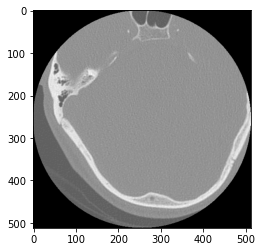

In [35]:
filename =('./train_images/1.2.826.0.1.3680043.10001/1.dcm')
ds = pydicom.dcmread(filename)
plt.imshow(ds.pixel_array,cmap = plt.cm.gray)

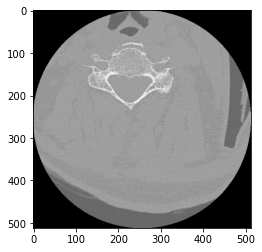

In [90]:
filename =('./train_images/1.2.826.0.1.3680043.10051/133.dcm')
ds = pydicom.dcmread(filename)
plt.imshow(ds.pixel_array,cmap = plt.cm.gray)

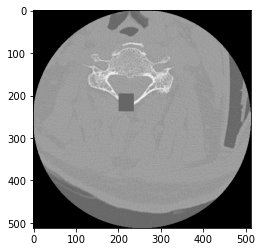

In [91]:
test_UID = '1.2.826.0.1.3680043.10051'
test_slice_number = 133
test_row = train_bounding_boxes.iloc[0]
test_points = {
    'x1' : test_row.x + test_row.width,
    'x2' : test_row.x - test_row.width,
    'y1' : test_row.y + test_row.height,
    'y2' : test_row.y - test_row.height
}
image = ds.pixel_array

start_point = (int(test_points['x1']), int(test_points['y1']))
end_point = (int(test_points['x2']), int(test_points['y2']))
color = (0,0,0)

image = cv2.rectangle(image, start_point, end_point, color, -1)
plt.imshow(image, cmap = plt.cm.gray)